In [1]:
# # Debugging RAovSeg Preprocessing
# 
# **Goal:** Determine the correct intensity thresholds for our specific dataset.
# The paper uses [0.22, 0.30], but our normalization or data distribution might differ.
# 
# **Method:**
# 1. Load a subset of patients from `D2_Half_Split`.
# 2. Extract pixel values *inside* the ovary mask vs. *outside*.
# 3. Plot histograms to find the "Ovary Peak".


import os
import numpy as np
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.auto import tqdm

# Config
DATA_ROOT = Path("../data/UT-EndoMRI/D2_Half_Split")
MANIFEST = DATA_ROOT / "d2_half_split_manifest.csv"

df = pd.read_csv(MANIFEST)

In [2]:
# ## 1. Collect Pixel Intensities
# We iterate through the Training set and collect pixel values.

ovary_pixels = []
background_pixels = []

print("Sampling pixel intensities...")

# Sample first 10 patients to save time
sample_df = df[df['split'] == 'train'].head(10)

for idx, row in tqdm(sample_df.iterrows(), total=len(sample_df)):
    img_path = DATA_ROOT / Path(row['t2fs_path']).name
    msk_path = DATA_ROOT / Path(row['ov_path']).name
    
    if not img_path.exists(): continue
        
    img_vol = nib.load(str(img_path)).get_fdata()
    msk_vol = nib.load(str(msk_path)).get_fdata()
    
    # Normalize per volume (Standard Min-Max 1-99%)
    # This matches our DataLoader logic
    p1 = np.percentile(img_vol, 1)
    p99 = np.percentile(img_vol, 99)
    img_norm = np.clip(img_vol, p1, p99)
    img_norm = (img_norm - img_norm.min()) / (img_norm.max() - img_norm.min() + 1e-8)
    
    # Extract pixels where Mask == 1 (Ovary)
    ovary_vals = img_norm[msk_vol > 0]
    ovary_pixels.extend(ovary_vals)
    
    # Extract pixels where Mask == 0 (Background)
    # We downsample background because there are too many pixels
    bg_vals = img_norm[msk_vol == 0]
    # Take random 1% of background pixels
    np.random.shuffle(bg_vals)
    background_pixels.extend(bg_vals[:len(ovary_vals)]) # Balance the histogram

print(f"Collected {len(ovary_pixels)} ovary pixels and {len(background_pixels)} background pixels.")

Sampling pixel intensities...


  0%|          | 0/10 [00:00<?, ?it/s]

Collected 27115 ovary pixels and 27115 background pixels.


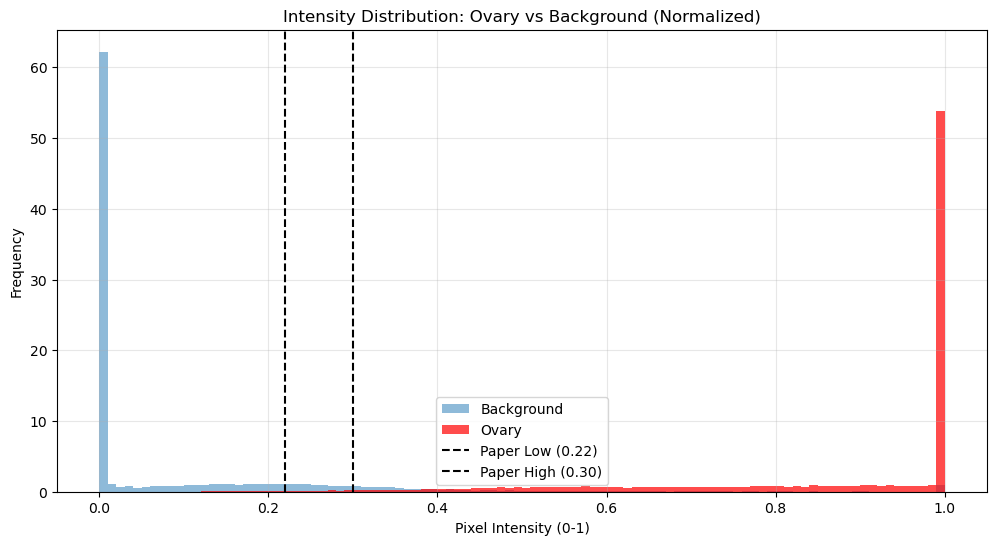

Ovary Mean: 0.8515
Ovary Median: 1.0000
Ovary 10th Percentile: 0.5010
Ovary 90th Percentile: 1.0000


In [3]:
# ## 2. Plot Histograms
# Where do the ovaries actually live?

plt.figure(figsize=(12, 6))

plt.hist(background_pixels, bins=100, alpha=0.5, label='Background', density=True, range=(0, 1))
plt.hist(ovary_pixels, bins=100, alpha=0.7, label='Ovary', color='red', density=True, range=(0, 1))

# Plot the paper's thresholds
plt.axvline(0.22, color='k', linestyle='--', label='Paper Low (0.22)')
plt.axvline(0.30, color='k', linestyle='--', label='Paper High (0.30)')

plt.title("Intensity Distribution: Ovary vs Background (Normalized)")
plt.xlabel("Pixel Intensity (0-1)")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Calculate statistics
ovary_pixels = np.array(ovary_pixels)
print(f"Ovary Mean: {np.mean(ovary_pixels):.4f}")
print(f"Ovary Median: {np.median(ovary_pixels):.4f}")
print(f"Ovary 10th Percentile: {np.percentile(ovary_pixels, 10):.4f}")
print(f"Ovary 90th Percentile: {np.percentile(ovary_pixels, 90):.4f}")

### ATTEMPT 2 

In [1]:
import os
import numpy as np
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.auto import tqdm

# Config: Use D2_Original to avoid the "half-black" skewing stats
DATA_ROOT = Path("../data/UT-EndoMRI/D2_Original")
MANIFEST = DATA_ROOT / "d2_original_manifest.csv"

df = pd.read_csv(MANIFEST)

In [2]:
ovary_pixels = []
background_pixels = []

# Sample more patients this time
sample_df = df[df['split'] == 'train'].head(20)

print("Sampling pixel intensities from D2_Original...")

for idx, row in tqdm(sample_df.iterrows(), total=len(sample_df)):
    img_path = DATA_ROOT / Path(row['t2fs_path']).name
    msk_path = DATA_ROOT / Path(row['ov_path']).name
    
    if not img_path.exists(): continue
        
    img_vol = nib.load(str(img_path)).get_fdata()
    msk_vol = nib.load(str(msk_path)).get_fdata()
    
    # Simple Min-Max Normalization (No percentile clipping)
    # This preserves the true peaks
    img_norm = (img_vol - img_vol.min()) / (img_vol.max() - img_vol.min() + 1e-8)
    
    # Extract Ovary Pixels
    ovary_vals = img_norm[msk_vol > 0]
    ovary_pixels.extend(ovary_vals)
    
    # Extract Background Pixels (Downsampled)
    bg_vals = img_norm[msk_vol == 0]
    if len(bg_vals) > len(ovary_vals):
        np.random.shuffle(bg_vals)
        bg_vals = bg_vals[:len(ovary_vals)] # Balance counts
    
    background_pixels.extend(bg_vals)

ovary_pixels = np.array(ovary_pixels)
background_pixels = np.array(background_pixels)

print(f"Collected {len(ovary_pixels)} ovary pixels.")

Sampling pixel intensities from D2_Original...


  0%|          | 0/20 [00:00<?, ?it/s]

Collected 64253 ovary pixels.


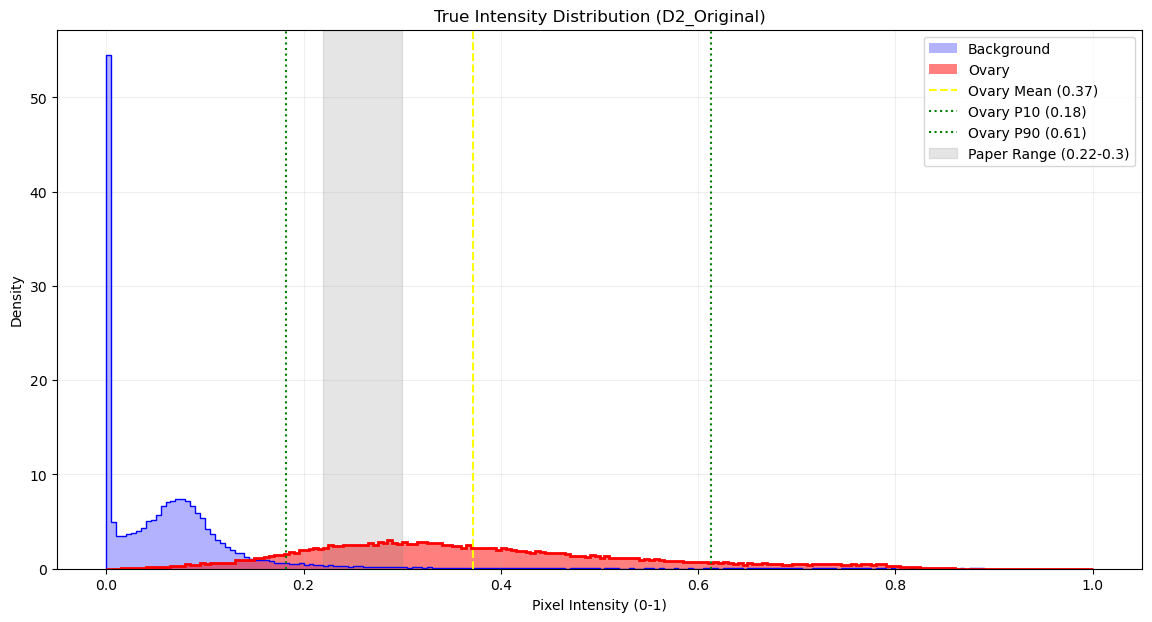

Ovary Range (10th-90th percentile): 0.1826 to 0.6127


In [3]:
plt.figure(figsize=(14, 7))

# Plot Background
plt.hist(background_pixels, bins=200, alpha=0.3, color='blue', label='Background', density=True, range=(0, 1))
plt.hist(background_pixels, bins=200, histtype='step', color='blue', density=True, range=(0, 1))

# Plot Ovary
plt.hist(ovary_pixels, bins=200, alpha=0.5, color='red', label='Ovary', density=True, range=(0, 1))
plt.hist(ovary_pixels, bins=200, histtype='step', color='red', density=True, range=(0, 1), linewidth=2)

# Plot Stats
mean_val = np.mean(ovary_pixels)
p10 = np.percentile(ovary_pixels, 10)
p90 = np.percentile(ovary_pixels, 90)

plt.axvline(mean_val, color='yellow', linestyle='--', label=f'Ovary Mean ({mean_val:.2f})')
plt.axvline(p10, color='green', linestyle=':', label=f'Ovary P10 ({p10:.2f})')
plt.axvline(p90, color='green', linestyle=':', label=f'Ovary P90 ({p90:.2f})')

# Plot the Paper's (Wrong) Thresholds for comparison
plt.axvspan(0.22, 0.30, color='gray', alpha=0.2, label='Paper Range (0.22-0.3)')

plt.title("True Intensity Distribution (D2_Original)")
plt.xlabel("Pixel Intensity (0-1)")
plt.ylabel("Density")
plt.legend()
plt.grid(True, alpha=0.2)
plt.show()

print(f"Ovary Range (10th-90th percentile): {p10:.4f} to {p90:.4f}")

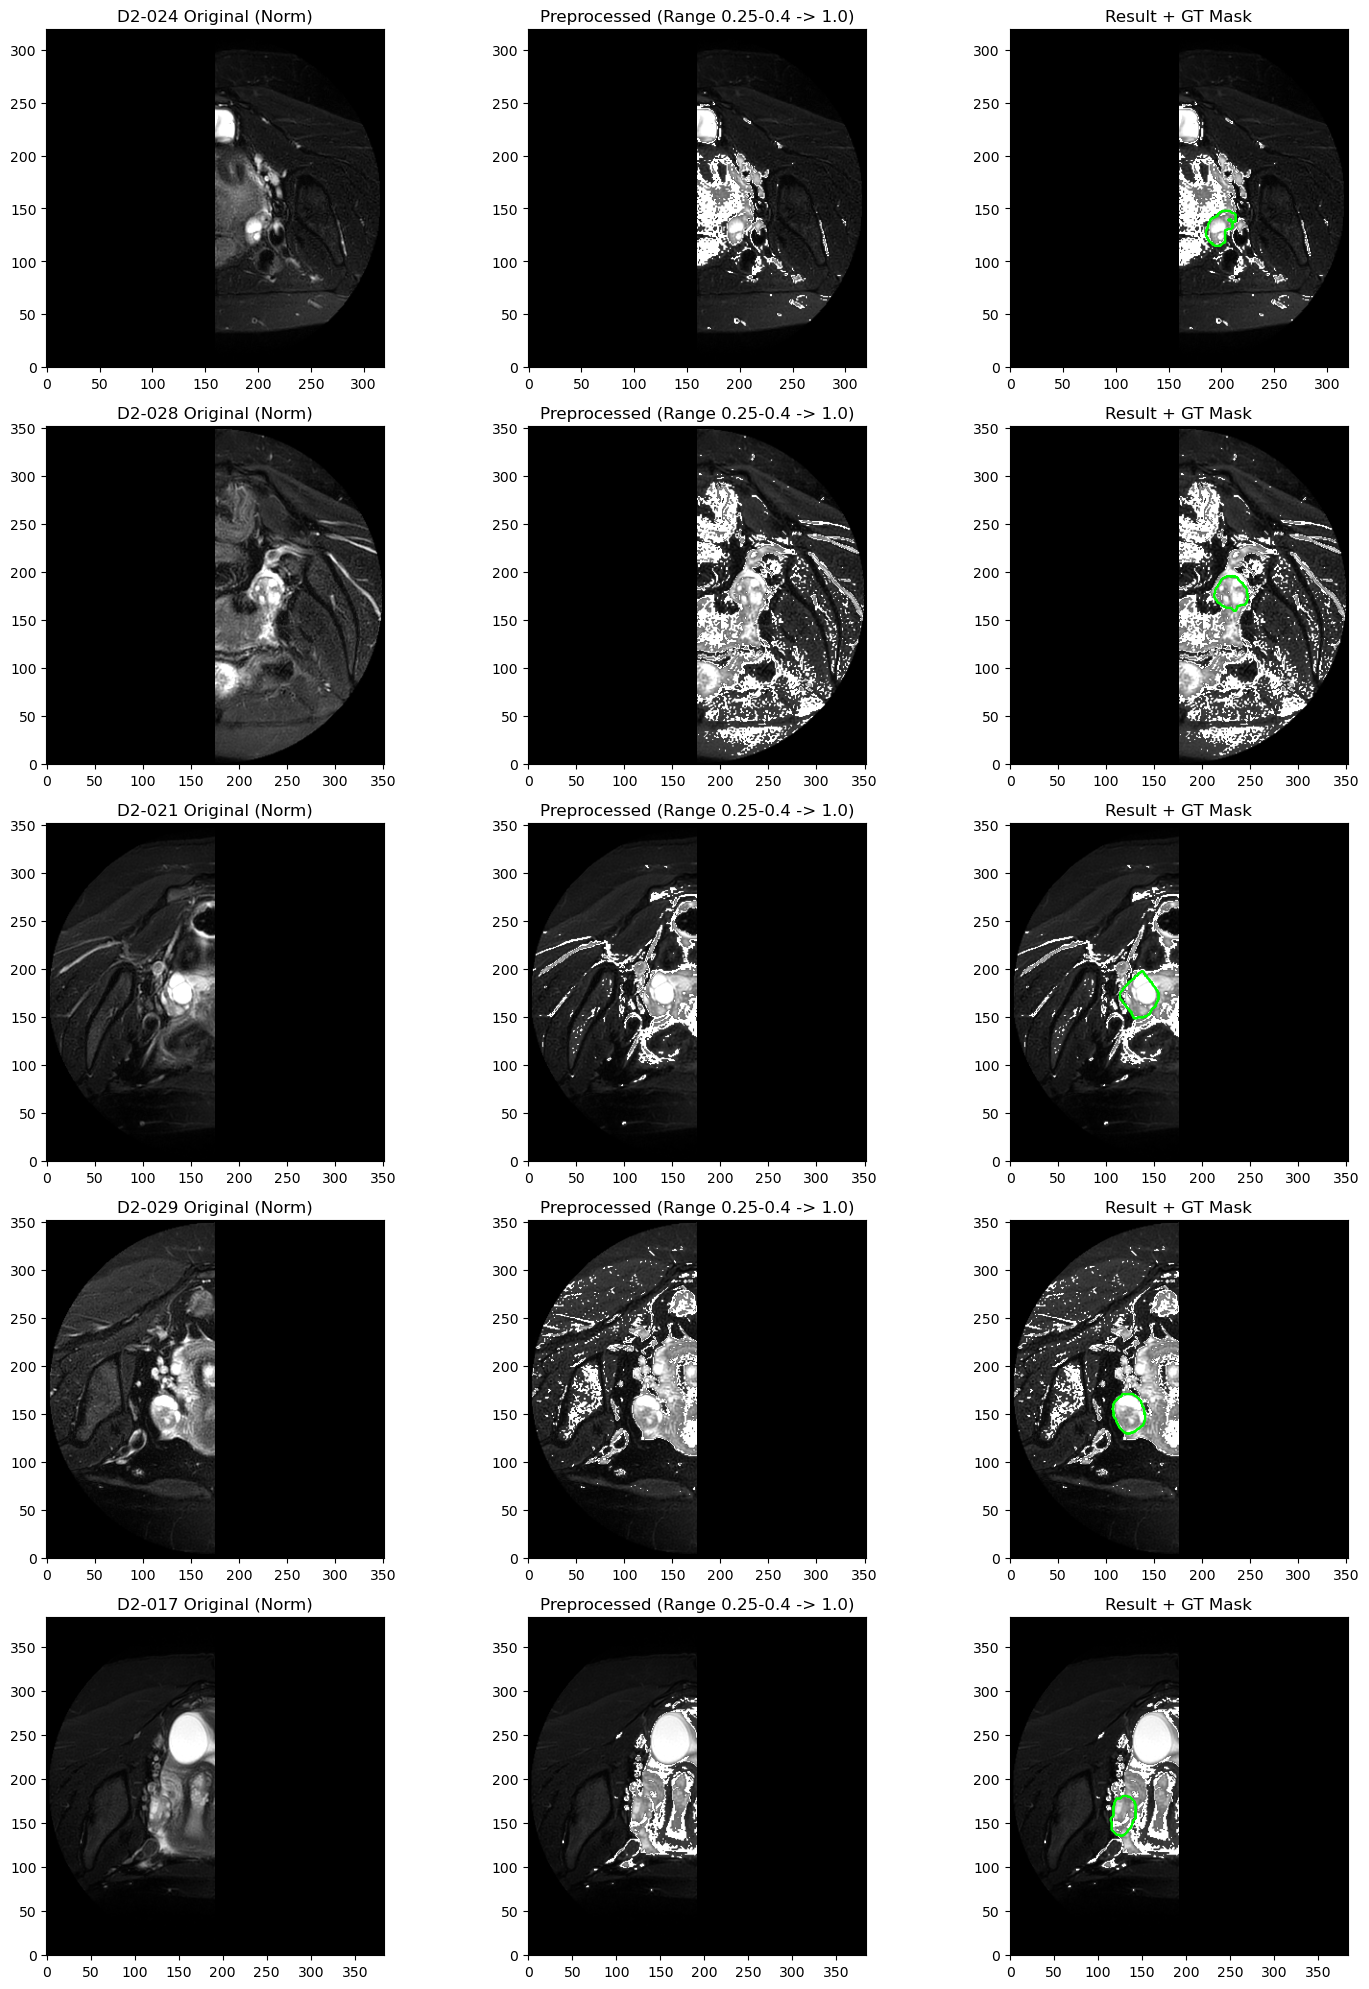

In [ ]:
# VISUALIZATION CELL: Test the "Data-Driven" Preprocessing
# Run this to verify the look before training.

def test_preprocessing_logic(dataset_path, manifest_path):
    df = pd.read_csv(manifest_path)
    root = Path(dataset_path)
    
    # Pick 5 random patients from Training set
    samples = df[df['split'] == 'train'].sample(5) # if you want different 5 samples each run
    
    fig, axes = plt.subplots(5, 3, figsize=(15, 20))
    
    for i, (idx, row) in enumerate(samples.iterrows()):
        # Load Data
        img_p = root / Path(row['t2fs_path']).name
        msk_p = root / Path(row['ov_path']).name
        
        if not img_p.exists(): continue
            
        img_vol = nib.load(str(img_p)).get_fdata()
        msk_vol = nib.load(str(msk_p)).get_fdata()
        
        # Find best slice
        z_sums = np.sum(msk_vol, axis=(0,1))
        best_z = np.argmax(z_sums)
        
        img = img_vol[:, :, best_z]
        msk = msk_vol[:, :, best_z]
        
        # --- LOGIC TO TEST ---
        # 1. Normalize based on NON-ZERO pixels (handling Half-Split)
        valid_pixels = img[img > 0]
        if len(valid_pixels) > 0:
            p1 = np.percentile(valid_pixels, 1)
            p99 = np.percentile(valid_pixels, 99)
            img_norm = np.clip(img, p1, p99)
            img_norm = (img_norm - p1) / (p99 - p1 + 1e-8)
            img_norm = np.clip(img_norm, 0, 1)
        else:
            img_norm = img # Should not happen
            
        # 2. Apply Thresholds
        o1 = 0.25 # Your suggestion
        o2 = 0.40
        
        img_proc = img_norm.copy()
        
        # The "Pop" Logic
        mask_ovary = (img_norm >= o1) & (img_norm <= o2)
        img_proc[mask_ovary] = 1.0
        
        # Optional: Suppress background? 
        # Uncomment next line to see what happens if we kill background < 0.21
        # img_proc[img_norm < o1] = 0.0 
        # ---------------------
        
        # Plotting
        # Col 1: Original Normalized
        axes[i, 0].imshow(img_norm.T, cmap='gray', origin='lower')
        axes[i, 0].set_title(f"{row['pid']} Original (Norm)")
        
        # Col 2: Preprocessed
        axes[i, 1].imshow(img_proc.T, cmap='gray', origin='lower')
        axes[i, 1].set_title(f"Preprocessed (Range {o1}-{o2} -> 1.0)")
        
        # Col 3: GT Mask Overlay
        axes[i, 2].imshow(img_proc.T, cmap='gray', origin='lower')
        axes[i, 2].contour(msk.T, colors='lime', linewidths=1)
        axes[i, 2].set_title("Result + GT Mask")
        
    plt.tight_layout()
    plt.show()

# Run it on D2_Half_Split
DATA_ROOT = "../data/UT-EndoMRI/D2_Half_Split"
MANIFEST = "../data/UT-EndoMRI/D2_Half_Split/d2_half_split_manifest.csv"

test_preprocessing_logic(DATA_ROOT, MANIFEST)

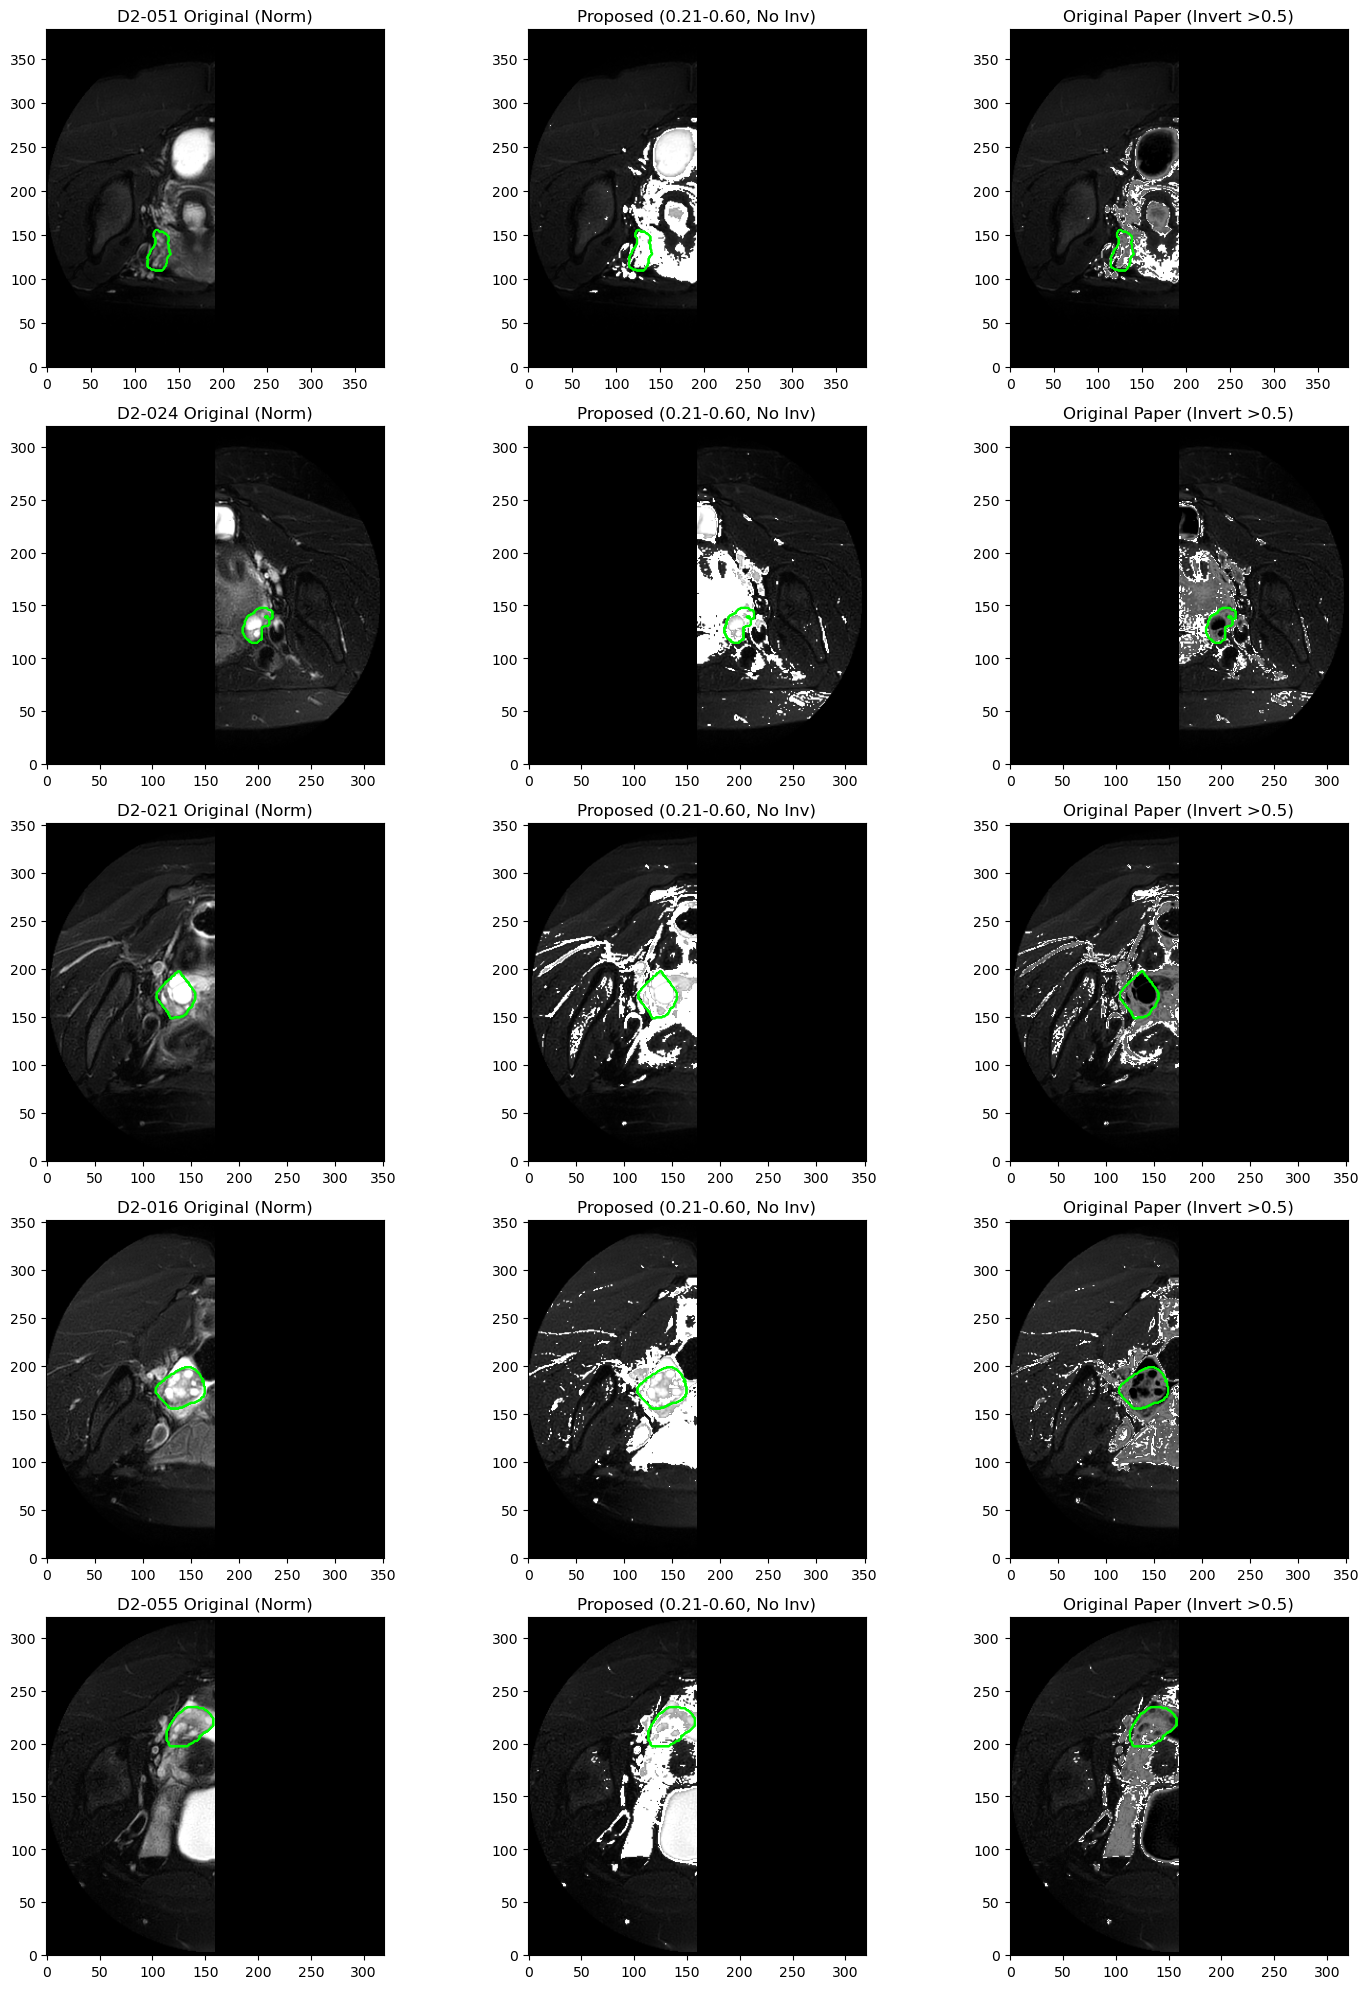

In [5]:
# VISUALIZATION: A/B Test (Proposed vs. Original Paper Logic)

def compare_preprocessing_strategies(dataset_path, manifest_path):
    df = pd.read_csv(manifest_path)
    root = Path(dataset_path)
    
    # Pick 5 random patients
    samples = df[df['split'] == 'train'].sample(5, random_state=42) # Fixed seed to keep same patients
    
    fig, axes = plt.subplots(5, 3, figsize=(15, 20))
    
    for i, (idx, row) in enumerate(samples.iterrows()):
        # Load Data
        img_p = root / Path(row['t2fs_path']).name
        msk_p = root / Path(row['ov_path']).name
        
        if not img_p.exists(): continue
            
        img_vol = nib.load(str(img_p)).get_fdata()
        msk_vol = nib.load(str(msk_p)).get_fdata()
        
        # Find best slice
        z_sums = np.sum(msk_vol, axis=(0,1))
        best_z = np.argmax(z_sums)
        
        img = img_vol[:, :, best_z]
        msk = msk_vol[:, :, best_z]
        
        # --- COMMON NORMALIZATION ---
        valid_pixels = img[img > 0]
        if len(valid_pixels) > 0:
            p1 = np.percentile(valid_pixels, 1)
            p99 = np.percentile(valid_pixels, 99)
            img_norm = np.clip(img, p1, p99)
            img_norm = (img_norm - p1) / (p99 - p1 + 1e-8)
            img_norm = np.clip(img_norm, 0, 1)
        else:
            img_norm = img
            
        # --- STRATEGY A: Data-Driven (Proposed) ---
        # No Inversion. Wide Range.
        img_prop = img_norm.copy()
        o1_prop, o2_prop = 0.21, 0.60
        img_prop[(img_norm >= o1_prop) & (img_norm <= o2_prop)] = 1.0
        
        # --- STRATEGY B: Original Paper Logic ---
        # Invert High. Narrow Range.
        img_paper = img_norm.copy()
        o1_paper, o2_paper = 0.22, 0.30
        
        # 1. Invert High Intensities (> 0.5)
        mask_high = (img_norm > 0.5)
        img_paper[mask_high] = 1.0 - img_norm[mask_high]
        
        # 2. Boost Ovary Range
        mask_ovary = (img_norm >= o1_paper) & (img_norm <= o2_paper)
        img_paper[mask_ovary] = 1.0
        
        # --- PLOTTING ---
        
        # Col 1: Original Normalized
        axes[i, 0].imshow(img_norm.T, cmap='gray', origin='lower')
        axes[i, 0].contour(msk.T, colors='lime', linewidths=1)
        axes[i, 0].set_title(f"{row['pid']} Original (Norm)")
        
        # Col 2: Proposed (Data-Driven)
        axes[i, 1].imshow(img_prop.T, cmap='gray', origin='lower')
        axes[i, 1].contour(msk.T, colors='lime', linewidths=1)
        axes[i, 1].set_title(f"Proposed (0.21-0.60, No Inv)")
        
        # Col 3: Original Paper
        axes[i, 2].imshow(img_paper.T, cmap='gray', origin='lower')
        axes[i, 2].contour(msk.T, colors='lime', linewidths=1)
        axes[i, 2].set_title(f"Original Paper (Invert >0.5)")
        
    plt.tight_layout()
    plt.show()

# Run Comparison
DATA_ROOT = "../data/UT-EndoMRI/D2_Half_Split"
MANIFEST = "../data/UT-EndoMRI/D2_Half_Split/d2_half_split_manifest.csv"

compare_preprocessing_strategies(DATA_ROOT, MANIFEST)